In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from collections import Counter
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

In [2]:
train_input = pd.read_csv('problem2/x_train.csv', header=None).values
train_target = pd.read_csv('problem2/t_train.csv', header=None).iloc[:, 0].values

In [3]:
# Standardization
train_input = pd.read_csv('problem2/x_train.csv', header=None)
train_input = ((train_input-train_input.mean())/train_input.std()).values
train_target = pd.read_csv('problem2/t_train.csv', header=None).iloc[:, 0].values

In [4]:
# https://scikit-learn.org/stable/modules/svm.html#multi-class-classification

In [5]:
class Kernel:
    def __init__(self, _type='linear'):
        self._type = _type
        self.phi_x = self.linear_phi if _type == 'linear' else self.poly_phi
    
    def linear_phi(self, x):
        return x
    
    def poly_phi(self, x):
        if len(x.shape) == 1:
            return np.vstack((x[0]**2, np.sqrt(2)*x[0]*x[1], x[1]**2)).T # shape: 1*3
        else:
            return np.vstack((x[:, 0]**2, np.sqrt(2)*x[:, 0]*x[:, 1], x[:, 1]**2)).T 
    
    def kernel_function(self, xn, xm):
        return np.dot(self.phi_x(xn), self.phi_x(xm).T)

class SVM:
    def __init__(self, _type='linear', C=1):
        self._type = _type
        self.kernel = Kernel(_type)
        self.class_label = [(0, 1), (0, 2), (1, 2)]
        self.C = C
        self.coef = None
        self.sv_index = None
    
    def fit(self, X, y):
        if self._type == 'linear':
            clf = SVC(kernel='linear', C=self.C, decision_function_shape='ovo')
        else:
            clf = SVC(kernel='poly', C=self.C, degree=2, decision_function_shape='ovo')
        clf.fit(X, y)
        # dual_coef_[i] = labels[i] * alphas[i] where labels[i] is either -1 or +1 and alphas[i] are always positive
        self.coef = np.abs(clf.dual_coef_) 
        self.sv_index = clf.support_  
        
    def prepare_parameter_for_classifiers(self, X):
        # target 
        target_dict = {}
        target_dict[(0, 1)] = np.concatenate((np.ones(50), np.full([50], -1), np.zeros(50)))
        target_dict[(0, 2)] = np.concatenate((np.ones(50), np.zeros(50), np.full([50], -1)))
        target_dict[(1, 2)] = np.concatenate((np.zeros(50), np.ones(50), np.full([50], -1)))
        
        # multiplier
        multiplier = np.zeros([len(X), 2])
        multiplier[self.sv_index] = self.coef.T 

        multiplier_dict = {}
        multiplier_dict[(0, 1)] = np.concatenate((multiplier[:100, 0], np.zeros(50)))
        multiplier_dict[(0, 2)] = np.concatenate((multiplier[:50, 1], np.zeros(50), multiplier[100:, 0]))
        multiplier_dict[(1, 2)] = np.concatenate((np.zeros(50), multiplier[50:, 1]))
        return target_dict, multiplier_dict
        
    def get_w_b(self, a, t, x):
        # PRML 7.29, 7.37
        at = a*t 
        w = at.dot(self.kernel.phi_x(x))
        
        M_indexes = np.where(((a > 0) & (a < self.C)))[0]
        S_indexes = np.nonzero(a)[0]
        Nm = len(M_indexes)
        
        if Nm == 0:
            b = -1 # ???
        else:
#             b = np.mean(t[M_indexes] - np.linalg.multi_dot([at[S_indexes], x[S_indexes], x[M_indexes].T]))
            b = np.mean(t[M_indexes] - at[S_indexes].dot(self.kernel.kernel_function(x[M_indexes], x[S_indexes]).T)) 
        
        return w, b
    
    def train(self, X, t):
        target_dict, multiplier_dict = self.prepare_parameter_for_classifiers(X)
        weight_dict = {}
        bias_dict = {}
        
        for c1, c2 in self.class_label:
            weight, bias = self.get_w_b(multiplier_dict[(c1, c2)], target_dict[(c1, c2)], X)
            weight_dict[(c1, c2)] = weight
            bias_dict[(c1, c2)] = bias
        return weight_dict, bias_dict
    
    def predict(self, X, weight_dict, bias_dict):
        prediction = []
        for index in range(len(X)):
            votes = []
            for c1, c2 in self.class_label:
                weight = weight_dict[(c1, c2)]
                bias = bias_dict[(c1, c2)]
                y = weight.dot(self.kernel.phi_x(X[index]).T) + bias
                if y > 0:
                    votes += [c1]
                else:
                    votes += [c2]
            prediction += [Counter(votes).most_common()[0][0]]
        return prediction
    
    def plot(self, X, t, xx, yy, prediction):
        class0_indexes = np.where(t == 1)
        class1_indexes = np.where(t == 2)
        class2_indexes = np.where(t == 3)
        plt.scatter(X[self.sv_index, 0], X[self.sv_index, 1], facecolors='none', edgecolors='k', linewidths=2, label="support vector")
        plt.scatter(X[class0_indexes][:, 0], X[class0_indexes][:, 1], c='r', marker='x', label="class 0")
        plt.scatter(X[class1_indexes][:, 0], X[class1_indexes][:, 1], c='g', marker='*', label="class 1")
        plt.scatter(X[class2_indexes][:, 0], X[class2_indexes][:, 1], c='b', marker='^', label="class 2")
        plt.legend()
        
        plt.contourf(xx, yy, prediction, alpha=0.3, cmap=plt.cm.coolwarm)
        
    def make_meshgrid(self, x, y, h=0.02):
        space = 0.3
        x_min, x_max = x.min() - space, x.max() + space
        y_min, y_max = y.min() - space, y.max() + space
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        return xx, yy

![](https://i.imgur.com/BUT6J6R.png)

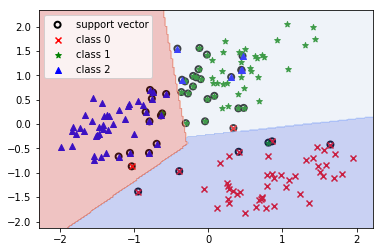

In [6]:
svm_linear = SVM()
svm_linear.fit(train_input, train_target)
weight_dict, bias_dict = svm_linear.train(train_input, train_target)
xx, yy = svm_linear.make_meshgrid(train_input[:, 0], train_input[:, 1])
prediction = svm_linear.predict(np.column_stack((xx.flatten(), yy.flatten())), weight_dict, bias_dict)
svm_linear.plot(train_input, train_target, xx, yy, np.array(prediction).reshape(xx.shape))

/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


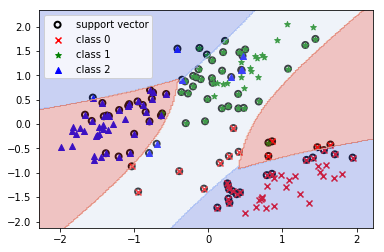

In [7]:
svm_poly = SVM(_type='poly')
svm_poly.fit(train_input, train_target)
weight_dict, bias_dict = svm_poly.train(train_input, train_target)
xx, yy = svm_poly.make_meshgrid(train_input[:, 0], train_input[:, 1])
prediction = svm_poly.predict(np.column_stack((xx.flatten(), yy.flatten())), weight_dict, bias_dict)
svm_poly.plot(train_input, train_target, xx, yy, np.array(prediction).reshape(xx.shape))

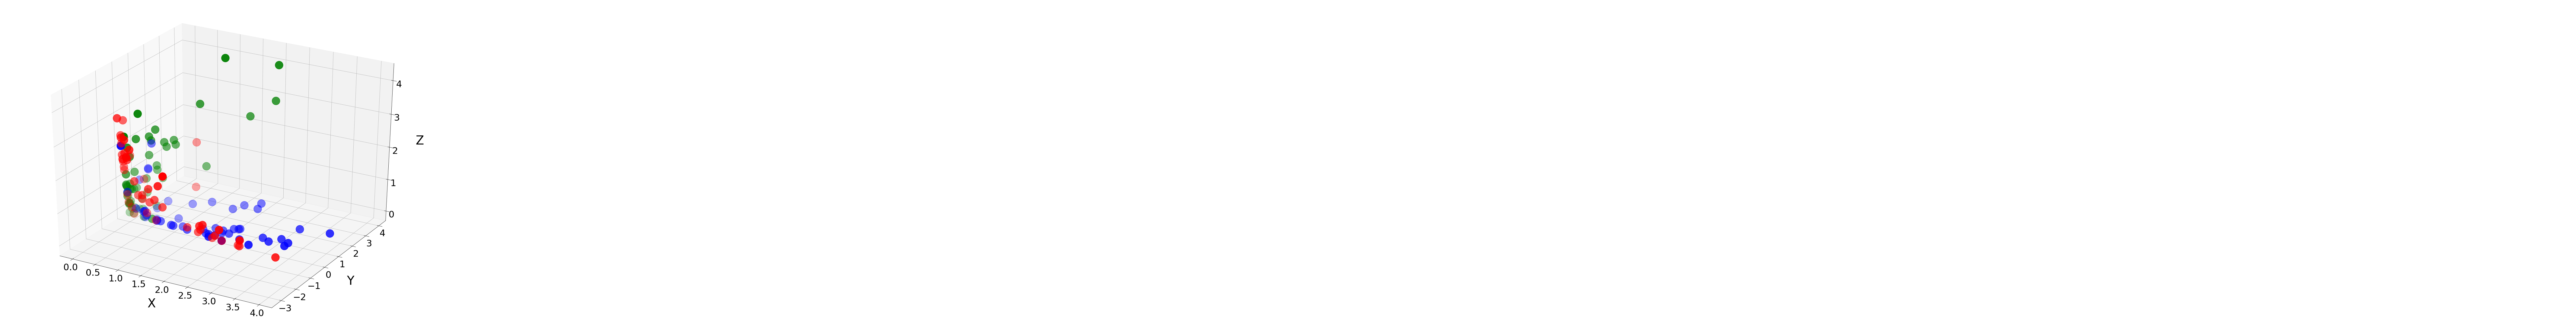

In [8]:
# Show data project to 3D
kernel = Kernel('poly')
data = kernel.phi_x(train_input)

fig = plt.figure(figsize=(20, 15))
ax = Axes3D(fig)
x, y, z = data[:, 0], data[:, 1], data[:, 2]
ax.scatter(x[:50], y[:50], z[:50], c='r', s=700)  # 绘制数据点
ax.scatter(x[50:100], y[50:100], z[50:100], c='g', s=700)
ax.scatter(x[100:], y[100:], z[100:], c='b', s=700)

ax.set_zlabel('Z', fontsize=40, labelpad=40)  # 坐标轴
ax.set_ylabel('Y', fontsize=40, labelpad=40)
ax.set_xlabel('X', fontsize=40, labelpad=40)
ax.tick_params(labelsize=30)
plt.savefig('problem2/project3d.png')
plt.show()